# Random Forest

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time

#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats #Para la moda
## Gráfica tabla
from tempfile import TemporaryDirectory
import joblib
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier # Se llama a la librería del método Random Forest

In [2]:
def loadModel(name):    
    path = "../../Models/" + name + ".pkl"
    clf = joblib.load(path)
    
    return clf;

In [3]:
def saveModel(clf, name):
    path = "../../Models/" + name + ".pkl"
    joblib.dump(clf, path) 

In [4]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    return X,Y;

In [5]:
def loadHD5(name):
    path = '../../Tables/'
    path += name + '.h5'
    return pd.read_hdf(path, 'df').values

In [6]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [8]:
def model_RF_F1(estimadores, caracteristicas, max_depth=None, impresion=True, classifier=None):
    if classifier is None:
        RF = RandomForestClassifier(n_estimators=estimadores, max_features=caracteristicas, max_depth=max_depth, n_jobs=-1)
    else:
        RF = classifier
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([5,2])
    accuracy_list_train = np.zeros([5,2])
    precision_list = np.zeros([5,2])
    precision_list_train = np.zeros([5,2])
    recall_list = np.zeros([5,2])
    recall_list_train = np.zeros([5,2])
    error = np.zeros([5,2])
    error_train = np.zeros([5,2])
    f_list = np.zeros([5,2]) 
    f1_train = np.zeros([5,2])
    
    feature_importances = np.zeros([5, X.shape[1]])
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, indexes in enumerate(skf.split(X, Y)):
        #Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2) # Modificar metodología de validación
        #scaler = MinMaxScaler() #Escala entre 0 y 1
        #Xtrain = scaler.fit_transform(Xtrain)
        #Xtest = scaler.transform(Xtest)
        
        Xtrain, Xtest = X[indexes[0]], X[indexes[1]]
        Ytrain, Ytest = Y[indexes[0]], Y[indexes[1]]

        #if classifier is None:
        RF.fit(Xtrain, Ytrain)
        
        pred = RF.predict(Xtest)
        pred_train = RF.predict(Xtrain)
        
        # accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[i] = _accuracy_

        _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        accuracy_list_train[i] = _accuracy_train_

        # recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[i] = _recalls_
        
        _recalls_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        recall_list_train[i] = _recalls_train_

        # precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[i] = _precisions_
        
        _precisions_train_ = precision_score(Ytrain, pred_train, average=None)
        precision_list_train[i] = _precisions_train_
        
        # f1
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[i] = _f_score_
        
        _f_score_train = f1_score(Ytrain, pred_train, average=None)
        f1_train[i] = _f_score_train
        
        feature_importances[i] = RF.feature_importances_
          
    if impresion:    
        #Curva ROC
        RF_probs = RF.predict_proba(Xtest)
        plot_roc(Xtest, Ytest, RF_probs, "RF")

        # Matriz Confusion
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)
        
        report = {
            'f1':[np.around(np.mean(f1_train), decimals=5), np.around(np.std(f1_train), decimals=5), np.around(np.mean(f_list), decimals=5), np.around(np.std(f_list), decimals=5)],
            'accuracy':[np.around(np.mean(accuracy_list_train), decimals=5), np.around(np.std(accuracy_list_train), decimals=5), np.around(np.mean(accuracy_list), decimals=5), np.around(np.std(accuracy_list), decimals=5)],
            'precision':[np.around(np.mean(precision_list_train), decimals=5), np.around(np.std(precision_list_train), decimals=5), np.around(np.mean(precision_list), decimals=5), np.around(np.std(precision_list), decimals=5)],
            'recall':[np.around(np.mean(recall_list_train), decimals=5), np.around(np.std(recall_list_train), decimals=5), np.around(np.mean(recall_list), decimals=5), np.around(np.std(recall_list), decimals=5)]
        }

        print(pd.DataFrame.from_dict(report, orient='index', columns=['Training score', '+/-', 'Test score', '+/-']))

        print("Total time:", time.time()-tiempo_i)
        
        # Plot feature importance
        
        plt.figure(figsize=(10,10))
        plt.plot(range(0, X.shape[1], 1), np.mean(feature_importances, axis=0))
        axes = plt.gca()
        #axes.set_ylim([3,10])
        #plt.axhline(y=0.02, color='r', linestyle='-')
        plt.ylabel('Feature importance')
        plt.xlabel('Feature index')
        plt.show()

    return np.mean(f1_train), np.std(f1_train), np.mean(f_list), np.std(f_list), time.time()-tiempo_i;

In [9]:
def grid_search(parameters):
    RF = RandomForestClassifier(n_jobs=-1)
    clf = GridSearchCV(RF, parameters, scoring='f1', n_jobs=-1, return_train_score=True)
    clf.fit(X,Y)
    return clf

In [10]:
def plot_grid_search(clf, parameters):
    # Get Test Scores Mean and std for each grid search
    scores_mean = clf.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(parameters['max_features']),len(parameters['n_estimators']))

    scores_sd = clf.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(parameters['max_features']),len(parameters['n_estimators']))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(20, 10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(parameters['max_features']):
        ax.plot(parameters['n_estimators'], scores_mean[idx,:], '-o', label= 'max_features' + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel('n_estimators', fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [11]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def vc(param_name, param_range, n_estimators=100, max_features='auto'):
    RF = RandomForestClassifier(n_estimators=estimadores, max_features=caracteristicas, n_jobs=-1)
    train_scores, test_scores = validation_curve(
        RF, X, Y, param_name=param_name, param_range=param_range,
        scoring="f1", n_jobs=1)
    return train_scores, test_scores;

# LSA 10k_1Col_NoCarEsp

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. Eliminando las 2 palabras que más aparecen y las que sólo aparecen 1-10 veces para hacer el LSA. 1200 tópicos.

In [7]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

In [8]:
a, b, c, d, e = model_RF_F1(100, 200)

Average train F1 score: 0.9998408656906429 +/- 0.00027562870903388183
Average test F1 score: 0.6816923520968525 +/- 0.012760145544702093
Average time: 23.50562882423401


In [ ]:
## Plot LC

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(n_estimators=100, max_features=200, n_jobs=-1)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

# Another stimator
#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                    cv=cv, n_jobs=4)

plt.show()

## LSA, 10k, sin caracteres especiales, 1500 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. 1500 tópicos.

In [12]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

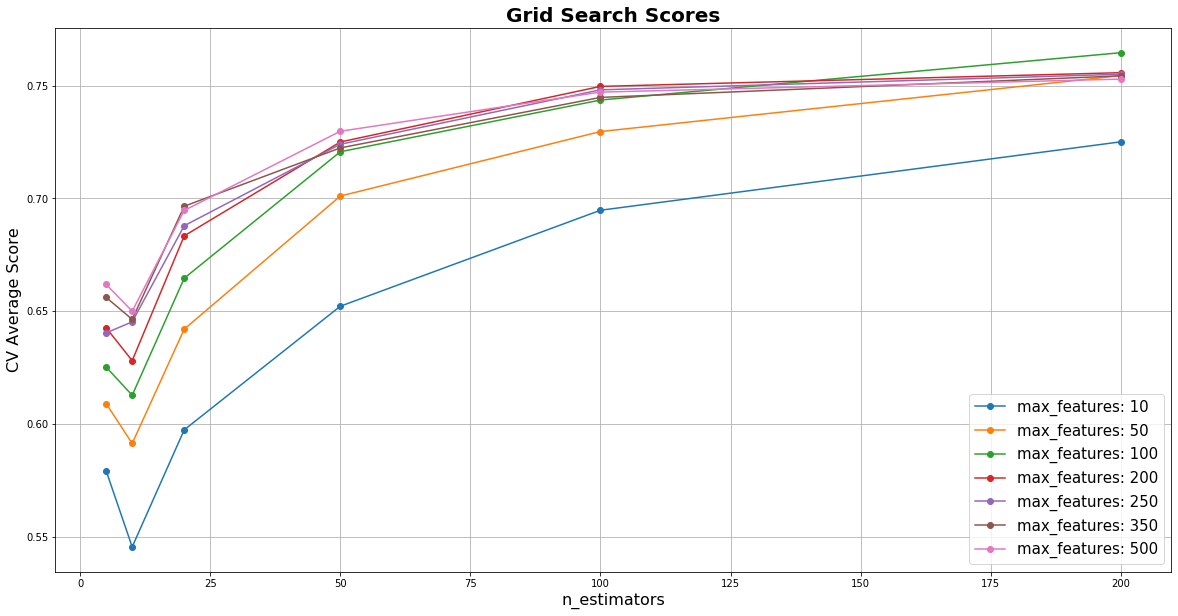

In [11]:
parameters = {'n_estimators':[5,10,20,50,100,200], 'max_features':[10,50,100,200,250,350,500]}
clf = grid_search(parameters)
clf.cv_results_
saveModel(clf_rbf, "RF_LSA_1500") 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.842


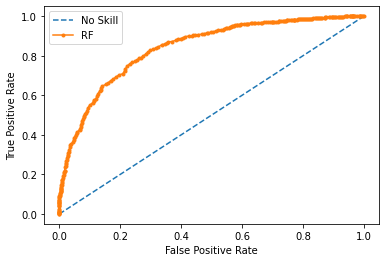

           Training score      +/-  Test score      +/-
f1                 0.9998  0.00010     0.76095  0.01669
accuracy           0.9998  0.00010     0.76180  0.00837
precision          0.9998  0.00015     0.76554  0.03242
recall             0.9998  0.00010     0.76180  0.06008
Total time: 603.2242069244385


(0.999799999996875,
 0.00010000000546873964,
 0.7609478856980813,
 0.01669285360823388,
 603.2242069244385)

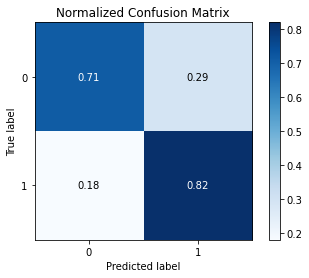

In [18]:
model_RF_F1(500, 100)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.700


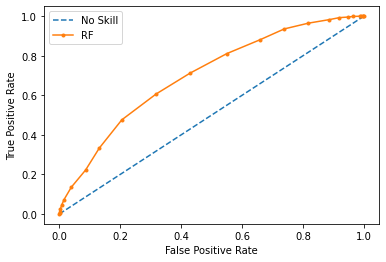

           Training score      +/-  Test score      +/-
f1                0.99977  0.00012     0.64046  0.01336
accuracy          0.99978  0.00012     0.64090  0.00447
precision         0.99978  0.00017     0.64160  0.01094
recall            0.99978  0.00012     0.64090  0.03534
Total time: 8.101030588150024


(0.9997749999957032,
 0.00012247449419579338,
 0.6404584207452511,
 0.013359168159916484,
 8.101030588150024)

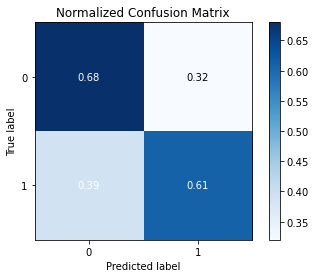

In [20]:
model_RF_F1(30, 15)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.848


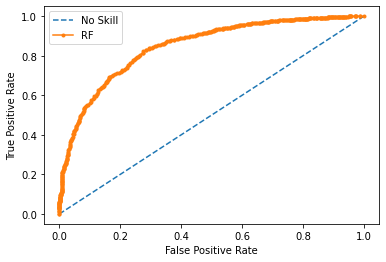

           Training score      +/-  Test score      +/-
f1                 0.9998  0.00010     0.76238  0.01895
accuracy           0.9998  0.00010     0.76340  0.01043
precision          0.9998  0.00022     0.76793  0.03613
recall             0.9998  0.00010     0.76340  0.06601
Total time: 1215.1697223186493


(0.9997999999906251,
 0.00010000001640623977,
 0.7623809801166569,
 0.018946953705075566,
 1215.1697223186493)

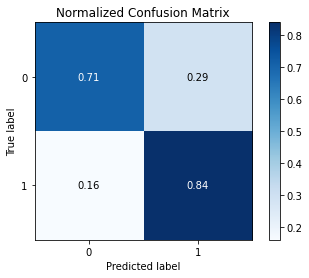

In [21]:
model_RF_F1(1000, 100)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.835


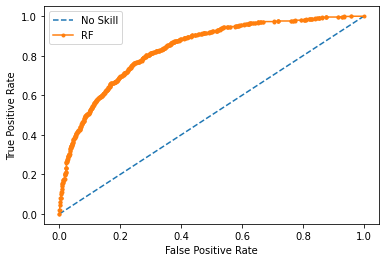

           Training score      +/-  Test score      +/-
f1                 0.9997  0.00013     0.75259  0.01503
accuracy           0.9997  0.00013     0.75320  0.00858
precision          0.9997  0.00022     0.75570  0.02668
recall             0.9997  0.00013     0.75320  0.05025
Total time: 229.19995021820068


(0.9996999999890626,
 0.0001274755138098861,
 0.7525917778492692,
 0.01502993355608307,
 229.19995021820068)

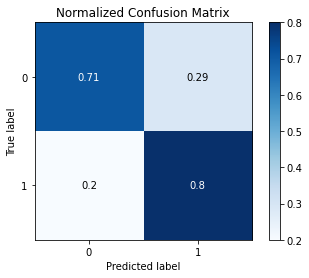

In [24]:
model_RF_F1(200, 100, max_depth=25)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.824


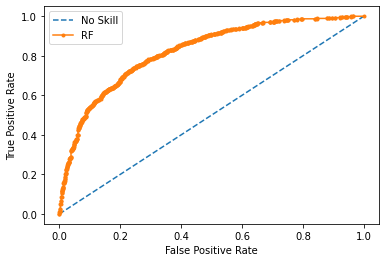

           Training score      +/-  Test score      +/-
f1                0.97815  0.00181     0.74722  0.01021
accuracy          0.97815  0.00180     0.74740  0.00764
precision         0.97837  0.01038     0.74810  0.01524
recall            0.97815  0.00180     0.74740  0.02771
Total time: 159.89318251609802


(0.9781475253032117,
 0.0018131758945902489,
 0.7472201901906341,
 0.010210180545861364,
 159.89318251609802)

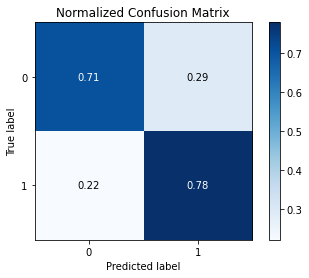

In [23]:
model_RF_F1(200, 100, max_depth=10)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.771


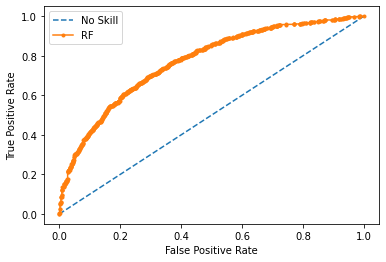

           Training score      +/-  Test score      +/-
f1                0.74364  0.00787     0.70602  0.01229
accuracy          0.74382  0.00360     0.70620  0.00982
precision         0.74452  0.01334     0.70672  0.01427
recall            0.74382  0.00360     0.70620  0.02684
Total time: 52.78923320770264


(0.7436399213532513,
 0.007867494622820222,
 0.7060161930706552,
 0.012288633566790445,
 52.78923320770264)

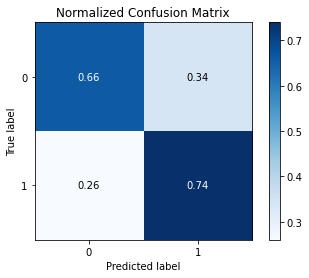

In [25]:
model_RF_F1(200, 100, max_depth=3)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.797


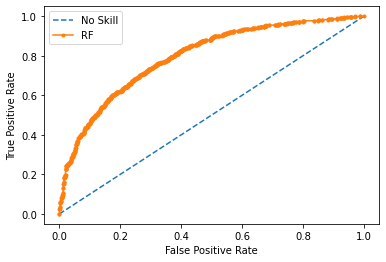

           Training score      +/-  Test score      +/-
f1                0.80532  0.00541     0.71955  0.00803
accuracy          0.80540  0.00387     0.71970  0.00470
precision         0.80589  0.01306     0.72018  0.01139
recall            0.80540  0.00387     0.71970  0.02380
Total time: 92.79260563850403


(0.8053233047057287,
 0.005412430297317586,
 0.7195476253139943,
 0.00803214678955693,
 92.79260563850403)

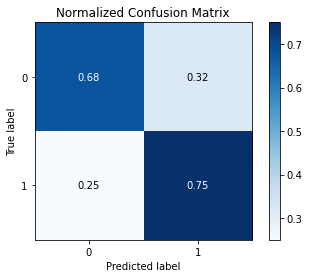

In [26]:
model_RF_F1(200, 100, max_depth=5)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.785


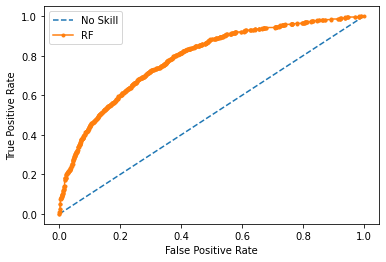

           Training score      +/-  Test score      +/-
f1                0.76822  0.00656     0.70953  0.01175
accuracy          0.76832  0.00431     0.70970  0.00939
precision         0.76883  0.01250     0.71021  0.01414
recall            0.76832  0.00431     0.70970  0.02631
Total time: 64.05026936531067


(0.7682180125685976,
 0.006557714297976802,
 0.7095255526673496,
 0.011746048815184275,
 64.05026936531067)

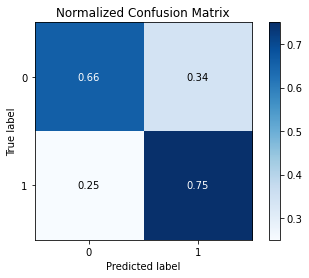

In [27]:
model_RF_F1(200, 100, max_depth=4)

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

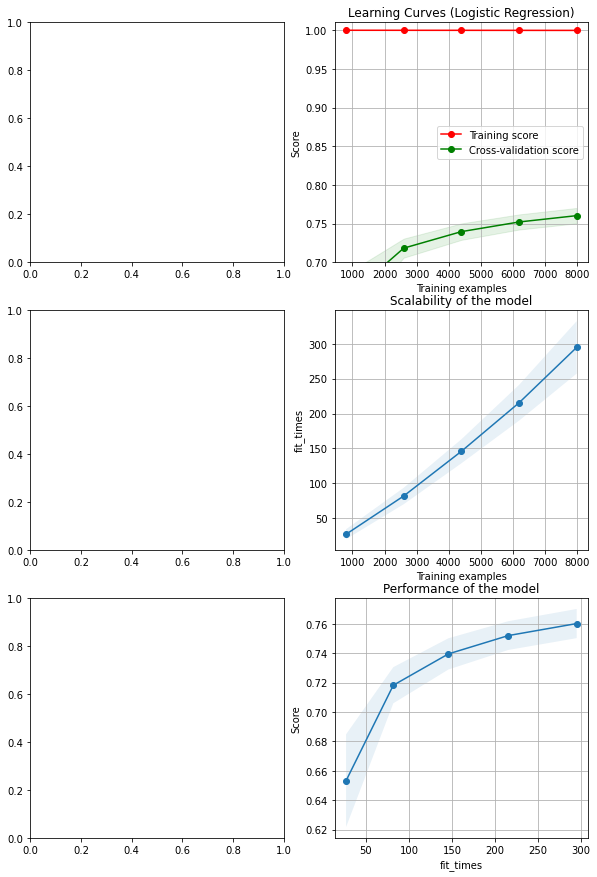

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

RF = RandomForestClassifier(n_estimators=200, max_features=100, n_jobs=-1)

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Logistic Regression)"

plot_learning_curve(RF, title, X, Y, axes=axes[:, 1], cv=cv, n_jobs=-1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

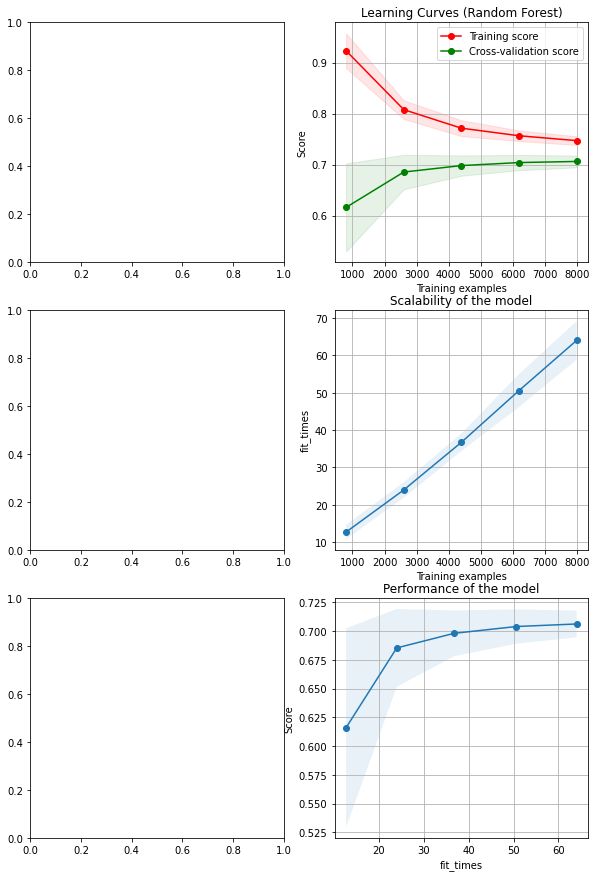

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

RF = RandomForestClassifier(n_estimators=200, max_features=100, n_jobs=-1, max_depth=3)

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Random Forest)"

plot_learning_curve(RF, title, X, Y, axes=axes[:, 1], cv=cv, n_jobs=-1)

In [31]:
parameters = {
    'n_estimators' : [5, 10, 20, 50, 100, 200], 
    'max_features' : [10, 50, 100, 200, 250, 350, 500], 
    'max_depth' : [3,4,5,7,10, None]
}
clf = grid_search(parameters)
print(clf.cv_results_)
saveModel(clf_rbf, "RF_LSA_1500") 

{'mean_fit_time': array([  13.56926713,    9.3577714 ,    2.26885777,    2.38162918,
          3.22158227,    6.51357627,    2.50789137,    1.99705672,
          3.38295045,    6.37035632,   16.08377542,   27.83095021,
          8.41389303,    4.41159902,    7.42852874,   18.23560357,
         32.41033053,   63.71346292,   12.57777376,    9.45351148,
         11.15535865,   36.99144716,   76.29230947,  133.57947364,
         15.40000482,   17.40375581,   21.16478343,   47.88630328,
         96.21132064,  171.74451313,   18.4697926 ,   25.01967154,
         30.71264277,   72.5924149 ,  139.20356617,  247.31450033,
         23.34246545,   36.57615733,   45.23419771,  103.24002857,
        204.55733905,  317.72175555,    9.53010674,    8.88164139,
          9.31807361,   11.79721694,   14.74016852,   14.22873759,
          5.8094593 ,    6.36497436,    8.56768103,    9.80836248,
         21.14643264,   43.62470303,   10.25895567,    6.27002745,
          8.67559233,   21.45660329,   48.65

NameError: name 'clf_rbf' is not defined

In [32]:
saveModel(clf, "RF_GS_LSA_1500") 

In [20]:
n = loadModel("../../Models/RF_GS_LSA_1500.pkl")

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.759


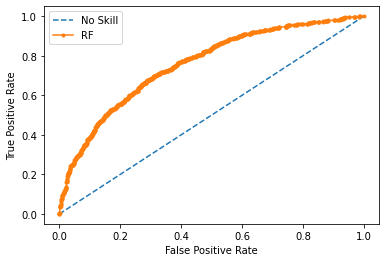

           Training score      +/-  Test score      +/-
f1                0.71329  0.01279     0.69046  0.01565
accuracy          0.71382  0.00307     0.69110  0.00663
precision         0.71544  0.01895     0.69268  0.01860
recall            0.71382  0.00307     0.69110  0.04584
Total time: 115.54248714447021


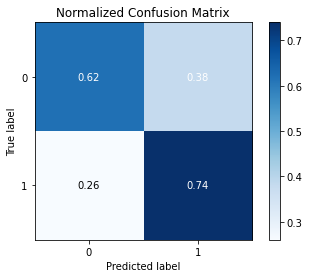

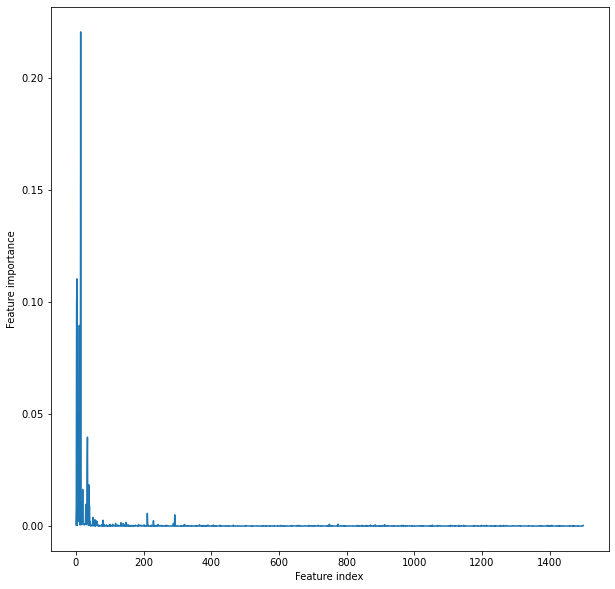

(0.7132898161286156,
 0.012791260359809523,
 0.690460301555754,
 0.015647583270603328,
 115.8185658454895)

In [28]:
model_RF_F1(0,0, classifier=n.best_estimator_.set_params(max_depth=3))

### Reduced features

#### Chi2 - 100 features

In [12]:
X = loadHD5('FS_Chi2_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.770


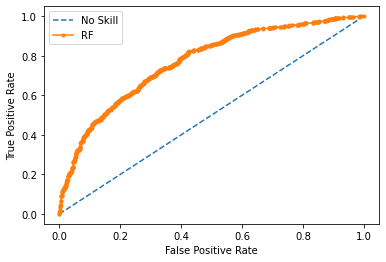

           Training score      +/-  Test score      +/-
f1                0.74189  0.00792     0.69809  0.01461
accuracy          0.74205  0.00471     0.69830  0.01236
precision         0.74268  0.01348     0.69887  0.01656
recall            0.74205  0.00471     0.69830  0.02922
Total time: 48.743614196777344


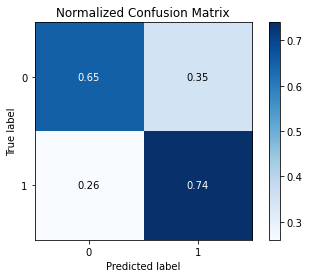

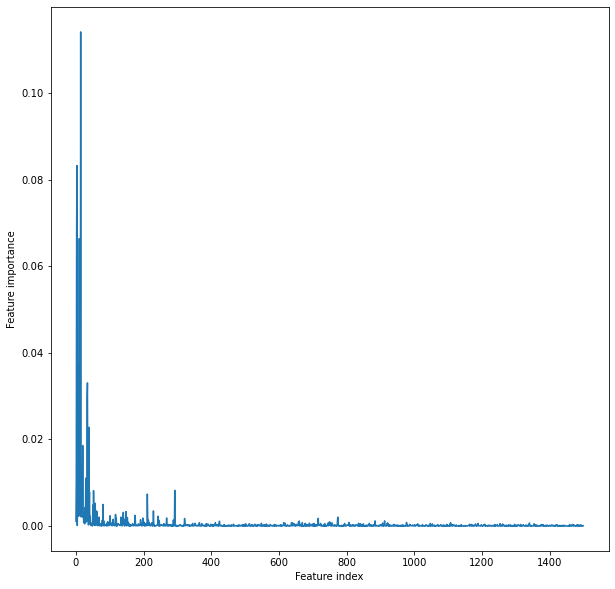

(0.74188726680492,
 0.007924645665649708,
 0.6980910055609423,
 0.01461068419751138,
 49.00792741775513)

In [19]:
model_RF_F1(200, 100, max_depth=3)

#### F-Value - 100 features

In [20]:
X = loadHD5('FS_Fisher_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.718


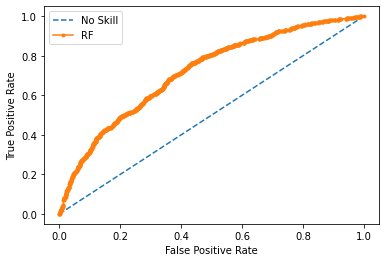

           Training score      +/-  Test score      +/-
f1                0.67232  0.02264     0.66143  0.02318
accuracy          0.67380  0.00340     0.66290  0.00636
precision         0.67696  0.02370     0.66584  0.02357
recall            0.67380  0.00340     0.66290  0.06619
Total time: 47.36590099334717


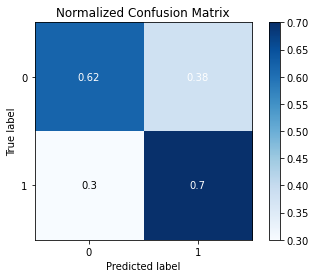

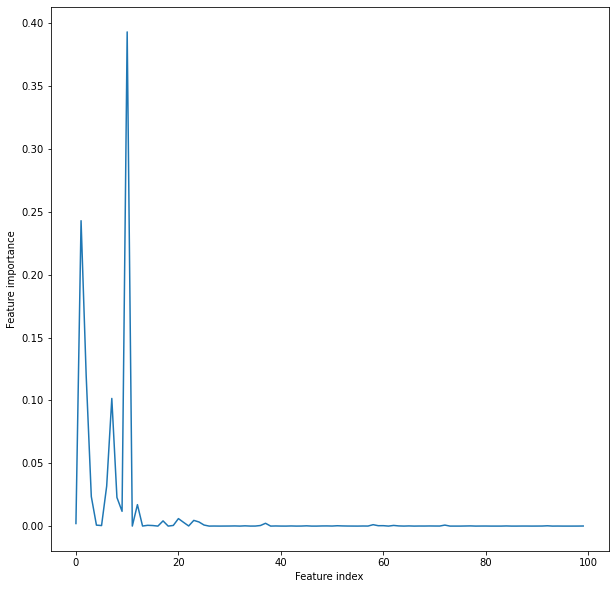

(0.6723203551682243,
 0.022643122124841146,
 0.6614300575772066,
 0.02318038591430825,
 47.627535343170166)

In [21]:
model_RF_F1(200, 100, max_depth=3)

#### Mutual Information - 100

In [22]:
X = loadHD5('FS_Mutual_Information_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.709


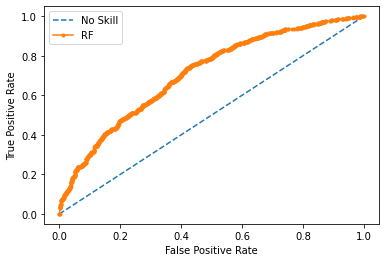

           Training score      +/-  Test score      +/-
f1                0.66629  0.01958     0.65567  0.02156
accuracy          0.66740  0.00218     0.65680  0.00882
precision         0.66965  0.01968     0.65894  0.02108
recall            0.66740  0.00218     0.65680  0.05792
Total time: 47.997618675231934


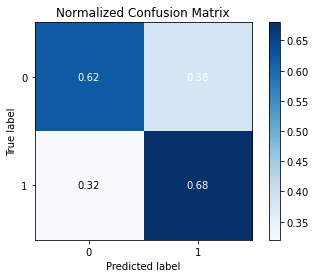

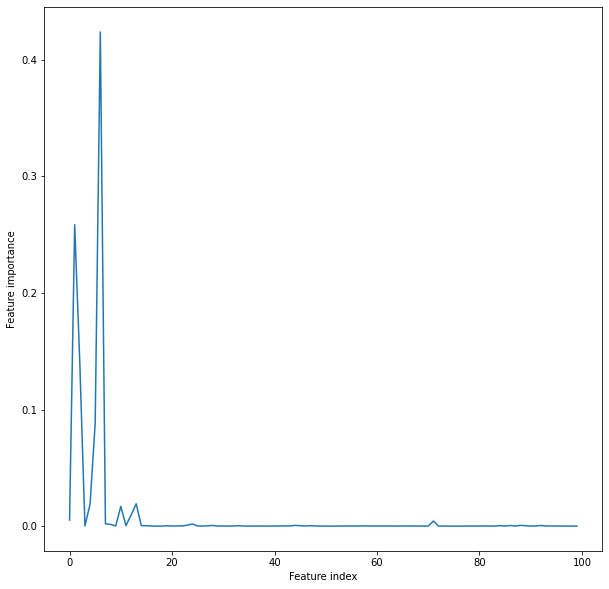

(0.6662905438393139,
 0.019584475795747503,
 0.6556721129886088,
 0.02155968846911784,
 48.20907926559448)

In [23]:
model_RF_F1(200, 100, max_depth=3)

#### LDA

In [16]:
X = loadHD5('LDA_LSA_1500')

In [17]:
model_RF_F1(200, 100, max_depth=3)

ValueError: max_features must be in (0, n_features]

#### PCA - 700

In [18]:
X = loadHD5('PCA_LSA_1500_700')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.775


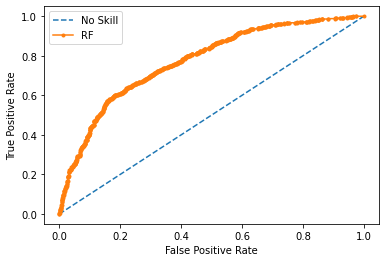

           Training score      +/-  Test score      +/-
f1                0.72132  0.00891     0.69615  0.01222
accuracy          0.72150  0.00531     0.69640  0.00825
precision         0.72204  0.01194     0.69701  0.01332
recall            0.72150  0.00531     0.69640  0.02949
Total time: 76.60009741783142


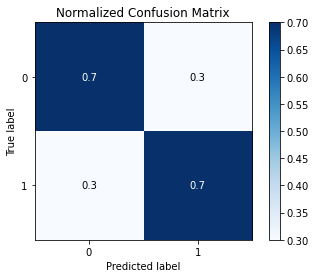

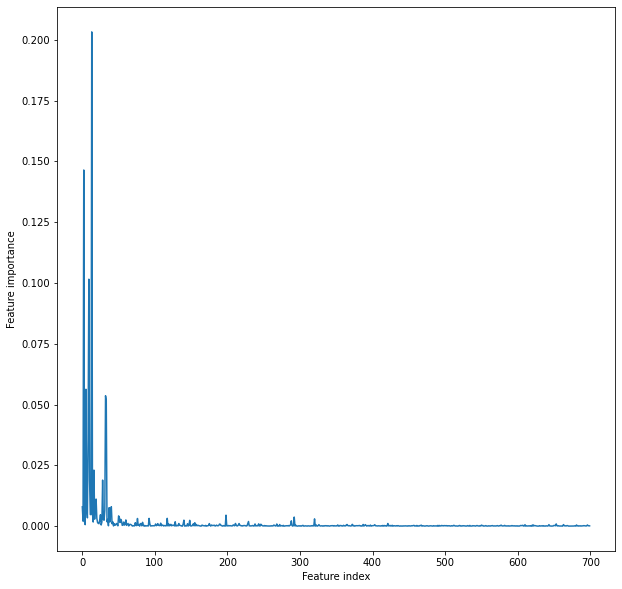

(0.7213245663986718,
 0.008908610236756709,
 0.6961505285141124,
 0.012220865293734477,
 78.84424304962158)

In [19]:
model_RF_F1(200, 100, max_depth=3)

#### SFS (Wrapper) - 100

In [12]:
sfs = loadModel('SFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sfs.k_feature_idx_]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.692


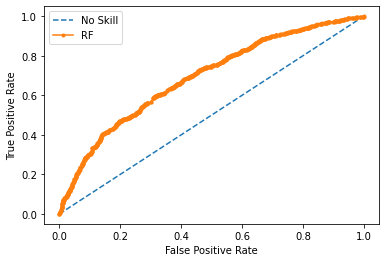

           Training score      +/-  Test score      +/-
f1                0.65798  0.01558     0.64516  0.01539
accuracy          0.65858  0.00548     0.64570  0.00690
precision         0.65965  0.01380     0.64661  0.01374
recall            0.65858  0.00548     0.64570  0.03970
Total time: 52.530996561050415


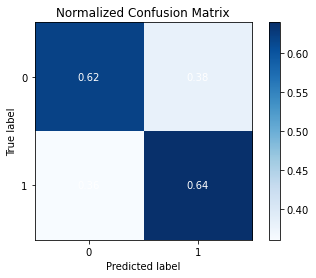

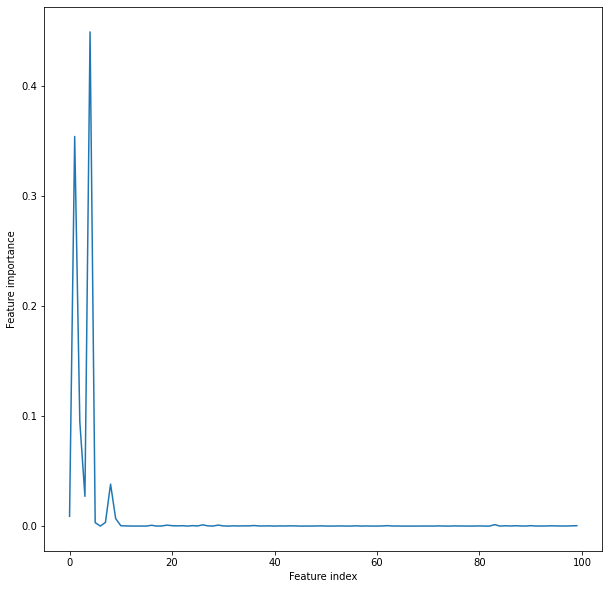

(0.657979078508901,
 0.01558486579399137,
 0.6451598322001055,
 0.015386080666879118,
 52.750025033950806)

In [13]:
model_RF_F1(200, 100, max_depth=3)

#### SFFS (Wrapper) - 100

In [14]:
sffs = loadModel('SFFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sffs.k_feature_idx_]

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.699


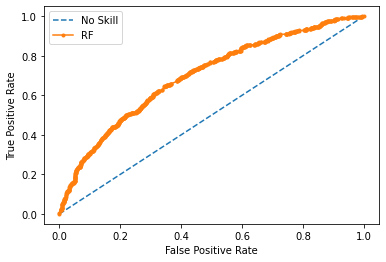

           Training score      +/-  Test score      +/-
f1                0.66223  0.00963     0.65341  0.00890
accuracy          0.66242  0.00494     0.65360  0.00348
precision         0.66278  0.00877     0.65395  0.00818
recall            0.66242  0.00494     0.65360  0.02393
Total time: 49.02814865112305


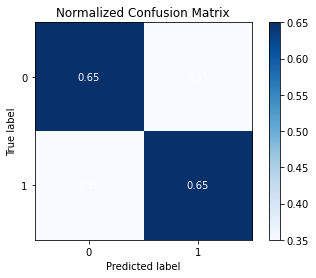

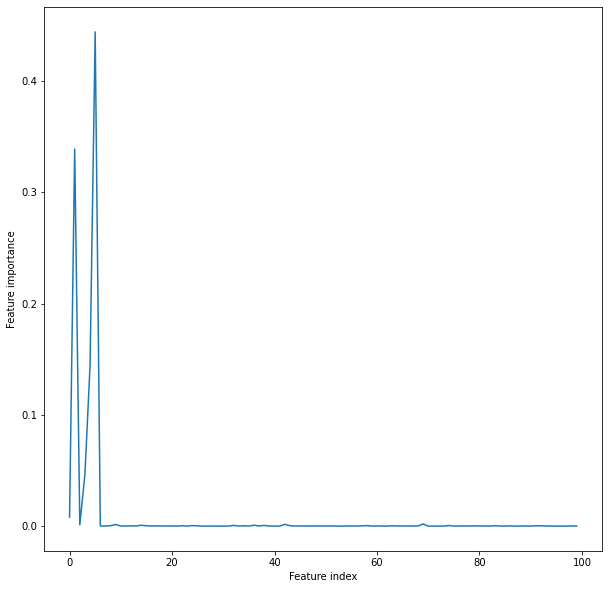

(0.6622325240429275,
 0.009630228236018255,
 0.6534058421747704,
 0.008901875927142594,
 49.472996950149536)

In [15]:
model_RF_F1(200, 100, max_depth=3)

#### Pearson correlation coefficient - 101

In [16]:
X = loadHD5('PEARSON_LSA_1500_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.642


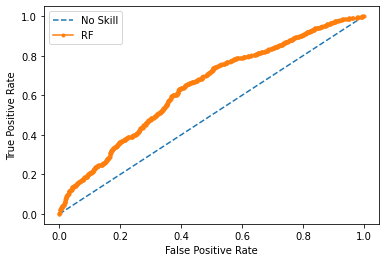

           Training score      +/-  Test score      +/-
f1                0.61364  0.02362     0.59659  0.02733
accuracy          0.61485  0.00901     0.59770  0.01711
precision         0.61627  0.01549     0.59878  0.02011
recall            0.61485  0.00901     0.59770  0.05511
Total time: 50.182594776153564


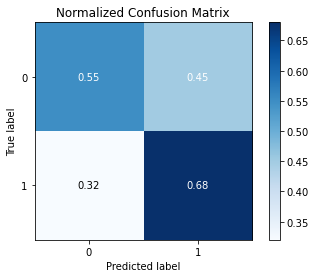

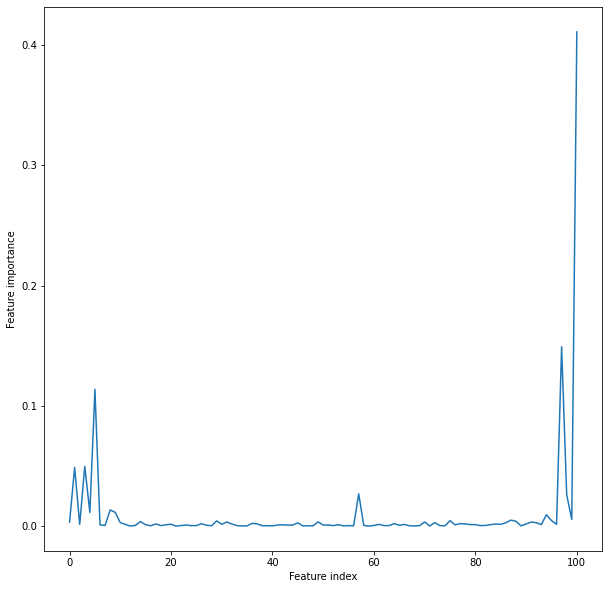

(0.6136443465270437,
 0.023618328716824673,
 0.5965890039046782,
 0.027333385882032254,
 50.40702509880066)

In [17]:
model_RF_F1(200, 100, max_depth=3)

# Doc2Vec, 1500 tópicos

In [15]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv")

In [16]:
X = loadHD5("Doc2Vec")

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.606


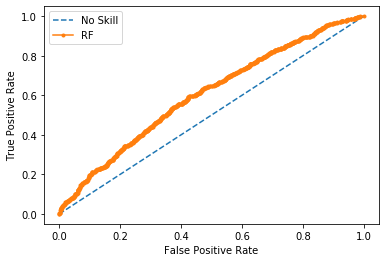

           Training score      +/-  Test score      +/-
f1                0.65482  0.00955     0.59160  0.02579
accuracy          0.65495  0.00674     0.59180  0.02421
precision         0.65517  0.00875     0.59199  0.02464
recall            0.65495  0.00674     0.59180  0.03273
Total time: 41.678749084472656


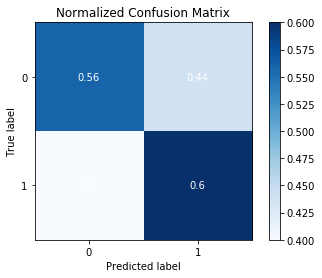

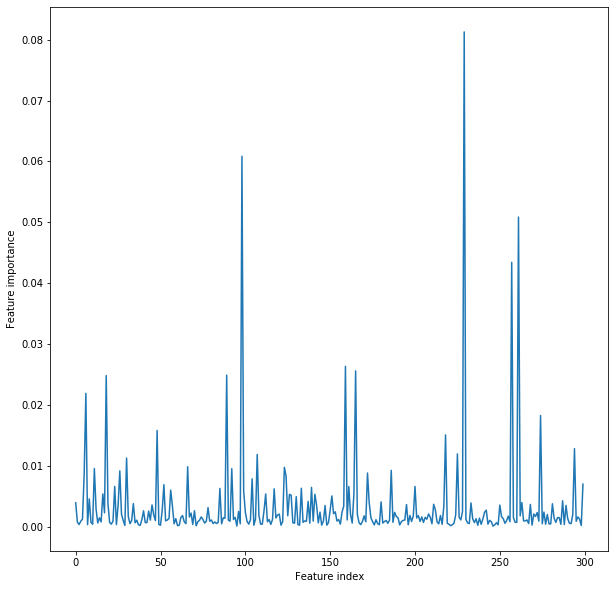

(0.6548230596489211,
 0.009546759865062334,
 0.5916034302018922,
 0.025786478571758524,
 41.971176624298096)

In [17]:
model_RF_F1(200, 100, max_depth=3)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.686


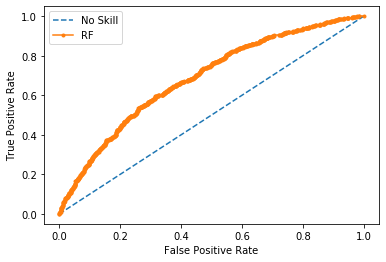

           Training score      +/-  Test score      +/-
f1                0.98370  0.00149     0.64824  0.02630
accuracy          0.98370  0.00147     0.64840  0.02514
precision         0.98413  0.01454     0.64866  0.02589
recall            0.98370  0.00147     0.64840  0.03293
Total time: 116.5777575969696


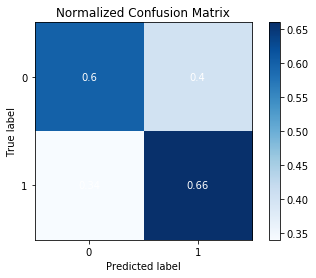

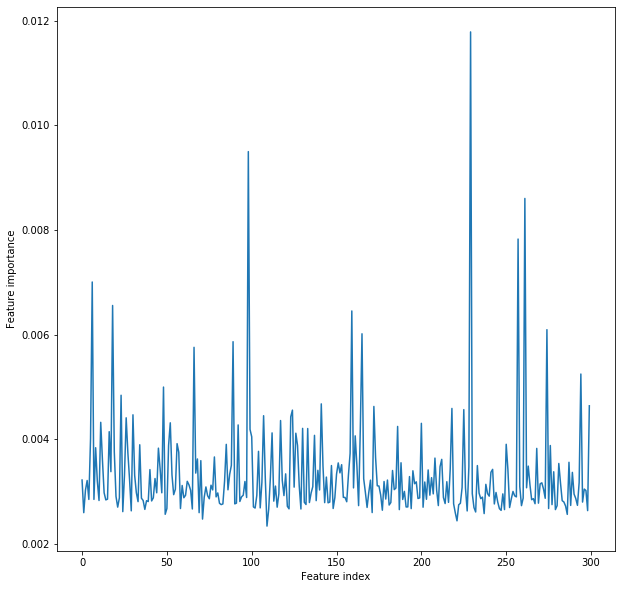

(0.9836962736908731,
 0.0014899877825230133,
 0.6482388196200822,
 0.02630138225574959,
 116.89790558815002)

In [18]:
model_RF_F1(200, 100, max_depth=10)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.608


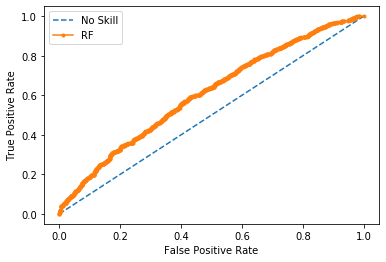

           Training score      +/-  Test score      +/-
f1                0.65655  0.00652     0.59186  0.02934
accuracy          0.65660  0.00479     0.59200  0.02836
precision         0.65670  0.00605     0.59214  0.02865
recall            0.65660  0.00479     0.59200  0.03400
Total time: 104.9292905330658


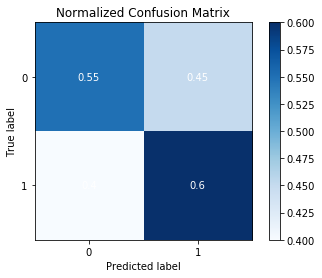

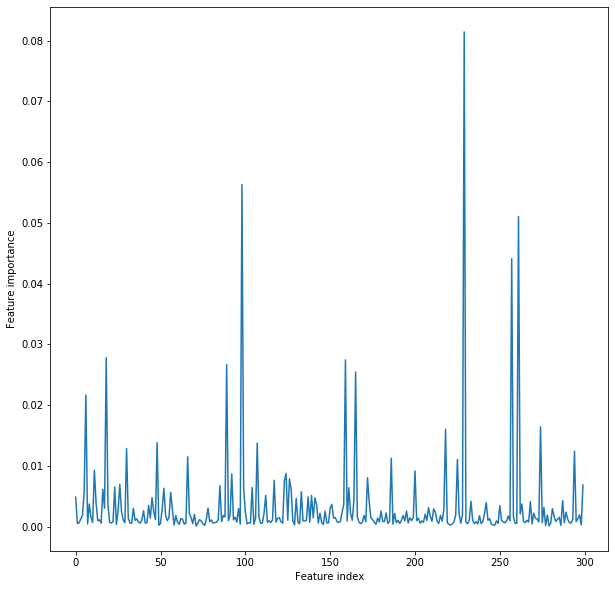

(0.6565453503435902,
 0.0065192862409068075,
 0.5918582143228874,
 0.029337781398783482,
 105.22486090660095)

In [19]:
model_RF_F1(500, 100, max_depth=3)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.685


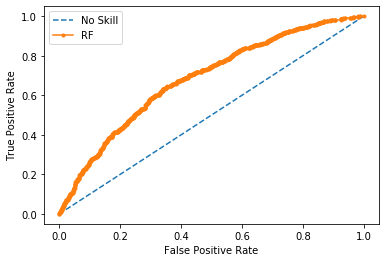

           Training score      +/-  Test score      +/-
f1                0.98252  0.00166     0.64060  0.01896
accuracy          0.98253  0.00163     0.64070  0.01798
precision         0.98301  0.01535     0.64085  0.01860
recall            0.98253  0.00163     0.64070  0.02447
Total time: 54.36844730377197


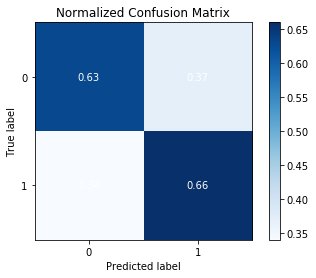

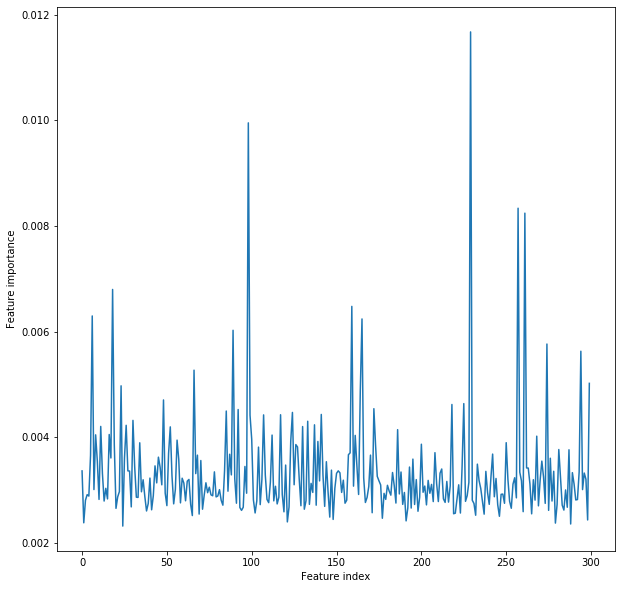

(0.9825205417066243,
 0.0016582507179192796,
 0.6406007004430752,
 0.018963498955310864,
 54.64084506034851)

In [20]:
model_RF_F1(100, 100, max_depth=10)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.685


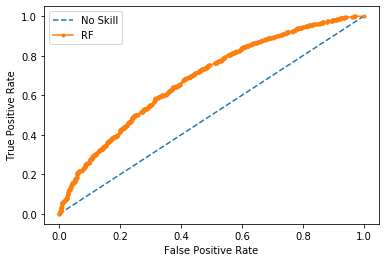

           Training score      +/-  Test score      +/-
f1                0.99997  0.00005     0.63590  0.02126
accuracy          0.99997  0.00005     0.63630  0.01726
precision         0.99998  0.00007     0.63688  0.01938
recall            0.99997  0.00005     0.63630  0.03732
Total time: 34.92780804634094


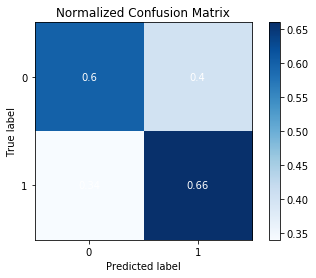

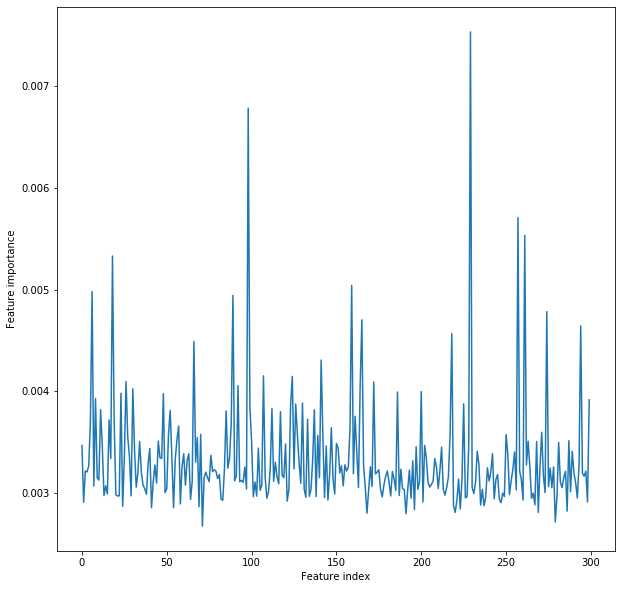

(0.9999749999996095,
 5.000000126953969e-05,
 0.6358963566226251,
 0.021256038592976652,
 35.19407844543457)

In [21]:
model_RF_F1(100, 50, max_depth=20)